# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2_matrix


2022-10-15_20-21-051i6ubnd9  train-152633_0.slurm.err  train-152633_2.slurm.out
2022-10-15_20-21-055x1s5ecg  train-152633_0.slurm.out  train-152633_3.slurm.err
2022-10-15_20-21-05l2jrttu4  train-152633_1.slurm.err  train-152633_3.slurm.out
2022-10-15_20-21-05n2r125tc  train-152633_1.slurm.out  train-152633_4.slurm.err
2022-10-15_20-21-05zvlbcbhk  train-152633_2.slurm.err  train-152633_4.slurm.out


In [2]:
!ls $SCRATCH/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30


2022-10-27_19-14-40v1v3_6dl  stdout.txt		       train-493234_2.slurm.out
2022-10-27_19-19-56_8ve71_y  train-493234_0.slurm.err  train-493234_3.slurm.err
2022-10-27_19-21-22pozgzx7i  train-493234_0.slurm.out  train-493234_3.slurm.out
2022-10-27_19-24-53kh4dr43g  train-493234_1.slurm.err  train-493234_4.slurm.err
2022-10-27_19-24-53qlfxv7fz  train-493234_1.slurm.out  train-493234_4.slurm.out
stderr.txt		     train-493234_2.slurm.err


In [2]:
!ls $SCRATCH/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30


2022-10-26_12-23-361jzdlx2z  train-448230_0.slurm.err  train-448230_2.slurm.out
2022-10-26_12-23-36pt_blwdm  train-448230_0.slurm.out  train-448230_3.slurm.err
2022-10-26_12-23-36tnspdchd  train-448230_1.slurm.err  train-448230_3.slurm.out
2022-10-26_12-23-36xdrwb902  train-448230_1.slurm.out  train-448230_4.slurm.err
2022-10-26_12-23-36y1qela3f  train-448230_2.slurm.err  train-448230_4.slurm.out


In [4]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
config_file="goal_lines_2agents_naming_game_all_modified.yml"
environment = PopGoalLinesEnv

# 6 landmarks
#config_file = "large_goal_lines_naming.yml"
#environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/all/modified_reward/3_landmarks/naming_game_30msg_alpha05_temp30/2022-10-20_01-15-1472rqeu15"

In [5]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
#config_file="goal_lines_2agents_naming_game_all_modified.yml"
#environment = PopGoalLinesEnv

# 6 landmarks
config_file = "large_goal_lines_2agents_naming_game_all_modified.yml"
environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm"

In [6]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-29 09:09:22,342	WARNING deprecation.py:46 -- DeprecationWarning: `ray.rllib.agents.ppo.ppo.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.agents.ppo.ppo.PPOConfig(...)` instead. This will raise an error in the future!
2022-10-29 09:09:23,042	WARNING multi_agent_env.py:225 -- observation_space_sample() has not been implemented
2022-10-29 09:09:23,043	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-29 09:09:23,044	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-29 09:09:23,044	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-29 09:09:23,044	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-29 09:09:23,045	WARNING multi_agent_env.py:161 -- action_space_contains() has not been implemented
2022-10-29 09:09:23,046	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented

# Inspecting matrices through time

2022-10-29 10:13:16,619	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000010/checkpoint-10
2022-10-29 10:13:16,620	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 562.121476650238, '_episodes_total': 1217}


checkpoint-10


2022-10-29 10:13:17,161	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000020/checkpoint-20
2022-10-29 10:13:17,164	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1094.9520466327667, '_episodes_total': 2597}


checkpoint-20
a


2022-10-29 10:13:18,965	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000030/checkpoint-30
2022-10-29 10:13:18,967	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1608.771410226822, '_episodes_total': 4066}


checkpoint-30


2022-10-29 10:13:19,597	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000040/checkpoint-40
2022-10-29 10:13:19,598	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2115.4443774223328, '_episodes_total': 5659}


checkpoint-40


2022-10-29 10:13:20,221	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000050/checkpoint-50
2022-10-29 10:13:20,222	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2600.420538187027, '_episodes_total': 7486}


checkpoint-50


2022-10-29 10:13:20,851	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000060/checkpoint-60
2022-10-29 10:13:20,851	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3085.9619402885437, '_episodes_total': 9626}


checkpoint-60


2022-10-29 10:13:21,485	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000070/checkpoint-70
2022-10-29 10:13:21,487	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3563.3611867427826, '_episodes_total': 11905}


checkpoint-70


2022-10-29 10:13:22,103	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000080/checkpoint-80
2022-10-29 10:13:22,105	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4036.6916766166687, '_episodes_total': 14877}


checkpoint-80


2022-10-29 10:13:22,730	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000090/checkpoint-90
2022-10-29 10:13:22,731	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4511.156648874283, '_episodes_total': 18147}


checkpoint-90


2022-10-29 10:13:24,015	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000100/checkpoint-100
2022-10-29 10:13:24,016	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 4982.300450563431, '_episodes_total': 21795}


checkpoint-100


2022-10-29 10:13:24,641	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000110/checkpoint-110
2022-10-29 10:13:24,641	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5439.09401011467, '_episodes_total': 25454}


checkpoint-110


2022-10-29 10:13:25,249	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000120/checkpoint-120
2022-10-29 10:13:25,250	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 5914.77533364296, '_episodes_total': 29105}


checkpoint-120


2022-10-29 10:13:25,873	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000130/checkpoint-130
2022-10-29 10:13:25,873	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6406.772386550903, '_episodes_total': 33122}


checkpoint-130


2022-10-29 10:13:26,538	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000140/checkpoint-140
2022-10-29 10:13:26,539	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 6881.6494307518005, '_episodes_total': 37238}


checkpoint-140


2022-10-29 10:13:27,179	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000150/checkpoint-150
2022-10-29 10:13:27,180	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7349.421119213104, '_episodes_total': 41312}


checkpoint-150


2022-10-29 10:13:27,801	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000160/checkpoint-160
2022-10-29 10:13:27,802	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 7784.809336423874, '_episodes_total': 45185}


checkpoint-160


2022-10-29 10:13:28,390	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000170/checkpoint-170
2022-10-29 10:13:28,393	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8218.5693089962, '_episodes_total': 49706}


checkpoint-170


2022-10-29 10:13:29,015	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000180/checkpoint-180
2022-10-29 10:13:29,016	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 8653.119589090347, '_episodes_total': 54955}


checkpoint-180


2022-10-29 10:13:29,651	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000190/checkpoint-190
2022-10-29 10:13:29,651	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 9082.835369110107, '_episodes_total': 60230}


checkpoint-190


2022-10-29 10:13:30,266	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000200/checkpoint-200
2022-10-29 10:13:30,266	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 9502.410031795502, '_episodes_total': 65137}


checkpoint-200


2022-10-29 10:13:30,881	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000210/checkpoint-210
2022-10-29 10:13:30,882	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 9926.601670742035, '_episodes_total': 70549}


checkpoint-210


2022-10-29 10:13:31,501	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000220/checkpoint-220
2022-10-29 10:13:31,502	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 10343.96875500679, '_episodes_total': 75922}


checkpoint-220


2022-10-29 10:13:32,698	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000230/checkpoint-230
2022-10-29 10:13:32,700	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 10756.82982826233, '_episodes_total': 81137}


checkpoint-230


2022-10-29 10:13:33,342	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000240/checkpoint-240
2022-10-29 10:13:33,343	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 11194.049307823181, '_episodes_total': 86164}


checkpoint-240


2022-10-29 10:13:33,943	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000250/checkpoint-250
2022-10-29 10:13:33,945	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 11620.094363212585, '_episodes_total': 91404}


checkpoint-250


2022-10-29 10:13:34,565	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000260/checkpoint-260
2022-10-29 10:13:34,566	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 12053.990909814835, '_episodes_total': 96681}


checkpoint-260


2022-10-29 10:13:35,167	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000270/checkpoint-270
2022-10-29 10:13:35,168	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 12498.38443851471, '_episodes_total': 102698}


checkpoint-270


2022-10-29 10:13:35,791	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000280/checkpoint-280
2022-10-29 10:13:35,792	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 12935.342216730118, '_episodes_total': 108529}


checkpoint-280


2022-10-29 10:13:36,425	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000290/checkpoint-290
2022-10-29 10:13:36,426	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 13380.83837223053, '_episodes_total': 114338}


checkpoint-290


2022-10-29 10:13:37,041	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000300/checkpoint-300
2022-10-29 10:13:37,046	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 13824.827579021454, '_episodes_total': 120284}


checkpoint-300


2022-10-29 10:13:37,686	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000310/checkpoint-310
2022-10-29 10:13:37,686	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 14291.235612630844, '_episodes_total': 126584}


checkpoint-310


2022-10-29 10:13:38,320	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000320/checkpoint-320
2022-10-29 10:13:38,321	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 14745.04335474968, '_episodes_total': 132732}


checkpoint-320


2022-10-29 10:13:38,959	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000330/checkpoint-330
2022-10-29 10:13:38,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 15173.285784006119, '_episodes_total': 138970}


checkpoint-330


2022-10-29 10:13:39,564	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000340/checkpoint-340
2022-10-29 10:13:39,565	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 15594.757323980331, '_episodes_total': 145226}


checkpoint-340


2022-10-29 10:13:40,188	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000350/checkpoint-350
2022-10-29 10:13:40,189	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 16015.982122182846, '_episodes_total': 151099}


checkpoint-350


2022-10-29 10:13:41,385	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000360/checkpoint-360
2022-10-29 10:13:41,388	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 16426.84485554695, '_episodes_total': 156828}


checkpoint-360


2022-10-29 10:13:42,029	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000370/checkpoint-370
2022-10-29 10:13:42,030	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 370, '_timesteps_total': None, '_time_total': 16854.964437007904, '_episodes_total': 162562}


checkpoint-370


2022-10-29 10:13:42,669	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000380/checkpoint-380
2022-10-29 10:13:42,670	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 17293.18014883995, '_episodes_total': 168552}


checkpoint-380


2022-10-29 10:13:43,301	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000390/checkpoint-390
2022-10-29 10:13:43,301	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 17735.04607772827, '_episodes_total': 174457}


checkpoint-390


2022-10-29 10:13:43,925	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000400/checkpoint-400
2022-10-29 10:13:43,926	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 18159.481841802597, '_episodes_total': 180604}


checkpoint-400


2022-10-29 10:13:44,552	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000410/checkpoint-410
2022-10-29 10:13:44,553	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 18581.80319094658, '_episodes_total': 186691}


checkpoint-410


2022-10-29 10:13:45,170	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000420/checkpoint-420
2022-10-29 10:13:45,170	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 19000.709248304367, '_episodes_total': 192717}


checkpoint-420


2022-10-29 10:13:45,795	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000430/checkpoint-430
2022-10-29 10:13:45,796	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 430, '_timesteps_total': None, '_time_total': 19418.12465238571, '_episodes_total': 198490}


checkpoint-430


2022-10-29 10:13:46,426	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000440/checkpoint-440
2022-10-29 10:13:46,427	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 19823.982088804245, '_episodes_total': 204098}


checkpoint-440


2022-10-29 10:13:47,054	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000450/checkpoint-450
2022-10-29 10:13:47,055	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': None, '_time_total': 20228.18304991722, '_episodes_total': 209700}


checkpoint-450


2022-10-29 10:13:47,688	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000460/checkpoint-460
2022-10-29 10:13:47,689	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 20635.207371234894, '_episodes_total': 215450}


checkpoint-460


2022-10-29 10:13:48,307	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000470/checkpoint-470
2022-10-29 10:13:48,309	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 21039.642280340195, '_episodes_total': 221192}


checkpoint-470


2022-10-29 10:13:48,932	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000480/checkpoint-480
2022-10-29 10:13:48,933	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 21452.029737710953, '_episodes_total': 227111}


checkpoint-480


2022-10-29 10:13:50,140	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000490/checkpoint-490
2022-10-29 10:13:50,141	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 490, '_timesteps_total': None, '_time_total': 21867.383573293686, '_episodes_total': 233114}


checkpoint-490


2022-10-29 10:13:50,771	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000500/checkpoint-500
2022-10-29 10:13:50,772	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 22276.293229818344, '_episodes_total': 238760}


checkpoint-500


2022-10-29 10:13:52,278	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000510/checkpoint-510
2022-10-29 10:13:52,283	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 510, '_timesteps_total': None, '_time_total': 22684.79279780388, '_episodes_total': 244366}


checkpoint-510


2022-10-29 10:13:52,912	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000520/checkpoint-520
2022-10-29 10:13:52,913	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 23102.513276338577, '_episodes_total': 249787}


checkpoint-520


2022-10-29 10:13:53,513	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000530/checkpoint-530
2022-10-29 10:13:53,513	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 23515.533206939697, '_episodes_total': 255297}


checkpoint-530


2022-10-29 10:13:54,154	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000540/checkpoint-540
2022-10-29 10:13:54,154	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 23930.743162870407, '_episodes_total': 260781}


checkpoint-540


2022-10-29 10:13:54,790	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000550/checkpoint-550
2022-10-29 10:13:54,791	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 550, '_timesteps_total': None, '_time_total': 24347.989007472992, '_episodes_total': 267217}


checkpoint-550


2022-10-29 10:13:55,422	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000560/checkpoint-560
2022-10-29 10:13:55,423	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 24773.495509386063, '_episodes_total': 274593}


checkpoint-560


2022-10-29 10:13:56,053	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000570/checkpoint-570
2022-10-29 10:13:56,058	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': None, '_time_total': 25198.427007198334, '_episodes_total': 282035}


checkpoint-570


2022-10-29 10:13:56,682	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000580/checkpoint-580
2022-10-29 10:13:56,683	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 25635.402944087982, '_episodes_total': 290236}


checkpoint-580


2022-10-29 10:13:57,314	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000590/checkpoint-590
2022-10-29 10:13:57,318	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 26082.3011367321, '_episodes_total': 298895}


checkpoint-590


2022-10-29 10:13:57,943	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000600/checkpoint-600
2022-10-29 10:13:57,944	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 26537.76534819603, '_episodes_total': 307766}


checkpoint-600


2022-10-29 10:13:59,160	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000610/checkpoint-610
2022-10-29 10:13:59,161	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 610, '_timesteps_total': None, '_time_total': 26983.659063339233, '_episodes_total': 316752}


checkpoint-610


2022-10-29 10:13:59,799	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000620/checkpoint-620
2022-10-29 10:13:59,800	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 27435.88044166565, '_episodes_total': 325937}


checkpoint-620


2022-10-29 10:14:00,422	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000630/checkpoint-630
2022-10-29 10:14:00,423	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 630, '_timesteps_total': None, '_time_total': 27883.091509342194, '_episodes_total': 335022}


checkpoint-630


2022-10-29 10:14:01,053	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000640/checkpoint-640
2022-10-29 10:14:01,054	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 28304.330394268036, '_episodes_total': 342827}


checkpoint-640


2022-10-29 10:14:01,672	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000650/checkpoint-650
2022-10-29 10:14:01,675	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 28750.362911224365, '_episodes_total': 351779}


checkpoint-650


2022-10-29 10:14:02,285	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000660/checkpoint-660
2022-10-29 10:14:02,291	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 29198.53289270401, '_episodes_total': 360732}


checkpoint-660


2022-10-29 10:14:02,907	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000670/checkpoint-670
2022-10-29 10:14:02,908	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 670, '_timesteps_total': None, '_time_total': 29648.281690359116, '_episodes_total': 369809}


checkpoint-670


2022-10-29 10:14:03,536	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000680/checkpoint-680
2022-10-29 10:14:03,537	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 30092.20274424553, '_episodes_total': 378889}


checkpoint-680


2022-10-29 10:14:04,178	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000690/checkpoint-690
2022-10-29 10:14:04,179	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 30540.03012895584, '_episodes_total': 387862}


checkpoint-690


2022-10-29 10:14:04,788	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000700/checkpoint-700
2022-10-29 10:14:04,789	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 30986.86992740631, '_episodes_total': 396565}


checkpoint-700


2022-10-29 10:14:05,403	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000710/checkpoint-710
2022-10-29 10:14:05,403	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 710, '_timesteps_total': None, '_time_total': 31430.923753023148, '_episodes_total': 405029}


checkpoint-710


2022-10-29 10:14:06,036	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000720/checkpoint-720
2022-10-29 10:14:06,037	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 31855.019484758377, '_episodes_total': 412788}


checkpoint-720


2022-10-29 10:14:06,659	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000730/checkpoint-730
2022-10-29 10:14:06,660	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 730, '_timesteps_total': None, '_time_total': 32278.36971282959, '_episodes_total': 420668}


checkpoint-730


2022-10-29 10:14:07,872	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000740/checkpoint-740
2022-10-29 10:14:07,872	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 32714.90452313423, '_episodes_total': 428797}


checkpoint-740


2022-10-29 10:14:08,498	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000750/checkpoint-750
2022-10-29 10:14:08,499	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 33155.79210233688, '_episodes_total': 436905}


checkpoint-750


2022-10-29 10:14:09,129	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000760/checkpoint-760
2022-10-29 10:14:09,130	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 33619.83811545372, '_episodes_total': 445442}


checkpoint-760


2022-10-29 10:14:09,753	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000770/checkpoint-770
2022-10-29 10:14:09,758	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 770, '_timesteps_total': None, '_time_total': 34097.42235946655, '_episodes_total': 454085}


checkpoint-770


2022-10-29 10:14:10,372	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000780/checkpoint-780
2022-10-29 10:14:10,376	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 34580.81082010269, '_episodes_total': 463021}


checkpoint-780


2022-10-29 10:14:11,006	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000790/checkpoint-790
2022-10-29 10:14:11,007	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 790, '_timesteps_total': None, '_time_total': 35065.604372262955, '_episodes_total': 472147}


checkpoint-790


2022-10-29 10:14:11,625	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000800/checkpoint-800
2022-10-29 10:14:11,626	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 35550.08249258995, '_episodes_total': 481119}


checkpoint-800


2022-10-29 10:14:12,265	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000810/checkpoint-810
2022-10-29 10:14:12,267	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 36023.80387830734, '_episodes_total': 489927}


checkpoint-810


2022-10-29 10:14:12,886	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000820/checkpoint-820
2022-10-29 10:14:12,887	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 36485.73113775253, '_episodes_total': 498215}


checkpoint-820


2022-10-29 10:14:13,498	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000830/checkpoint-830
2022-10-29 10:14:13,499	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 830, '_timesteps_total': None, '_time_total': 36953.771916627884, '_episodes_total': 506667}


checkpoint-830


2022-10-29 10:14:14,117	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000840/checkpoint-840
2022-10-29 10:14:14,118	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 37426.222881793976, '_episodes_total': 514969}


checkpoint-840


2022-10-29 10:14:14,732	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000850/checkpoint-850
2022-10-29 10:14:14,732	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 850, '_timesteps_total': None, '_time_total': 37899.79941391945, '_episodes_total': 523354}


checkpoint-850


2022-10-29 10:14:15,333	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000860/checkpoint-860
2022-10-29 10:14:15,334	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 38382.37141466141, '_episodes_total': 531650}


checkpoint-860


2022-10-29 10:14:16,524	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000870/checkpoint-870
2022-10-29 10:14:16,526	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 38861.494183540344, '_episodes_total': 540362}


checkpoint-870


2022-10-29 10:14:17,119	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000880/checkpoint-880
2022-10-29 10:14:17,121	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 39345.98356318474, '_episodes_total': 548981}


checkpoint-880


2022-10-29 10:14:17,770	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000890/checkpoint-890
2022-10-29 10:14:17,771	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 890, '_timesteps_total': None, '_time_total': 39828.293207883835, '_episodes_total': 557475}


checkpoint-890


2022-10-29 10:14:18,379	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000900/checkpoint-900
2022-10-29 10:14:18,380	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 40310.19192767143, '_episodes_total': 566046}


checkpoint-900


2022-10-29 10:14:18,999	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000910/checkpoint-910
2022-10-29 10:14:19,004	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 910, '_timesteps_total': None, '_time_total': 40792.47970366478, '_episodes_total': 574807}


checkpoint-910


2022-10-29 10:14:19,633	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000920/checkpoint-920
2022-10-29 10:14:19,633	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 41259.93725347519, '_episodes_total': 583093}


checkpoint-920


2022-10-29 10:14:20,258	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000930/checkpoint-930
2022-10-29 10:14:20,259	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 41736.99317526817, '_episodes_total': 591610}


checkpoint-930


2022-10-29 10:14:20,876	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000940/checkpoint-940
2022-10-29 10:14:20,880	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 42214.356935977936, '_episodes_total': 600251}


checkpoint-940


2022-10-29 10:14:21,471	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000950/checkpoint-950
2022-10-29 10:14:21,475	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 950, '_timesteps_total': None, '_time_total': 42696.29383516312, '_episodes_total': 608938}


checkpoint-950


2022-10-29 10:14:22,093	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000960/checkpoint-960
2022-10-29 10:14:22,095	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 43169.62419939041, '_episodes_total': 617283}


checkpoint-960


2022-10-29 10:14:22,722	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000970/checkpoint-970
2022-10-29 10:14:22,723	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 970, '_timesteps_total': None, '_time_total': 43645.163992881775, '_episodes_total': 625760}


checkpoint-970


2022-10-29 10:14:23,340	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000980/checkpoint-980
2022-10-29 10:14:23,342	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 44126.27603268623, '_episodes_total': 634868}


checkpoint-980


2022-10-29 10:14:23,955	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_000990/checkpoint-990
2022-10-29 10:14:23,956	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 44606.2908616066, '_episodes_total': 643743}


checkpoint-990


2022-10-29 10:14:25,168	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks_reward2/naming_game_30msg_alpha10_temp30/2022-10-26_12-23-36pt_blwdm/checkpoint_001000/checkpoint-1000
2022-10-29 10:14:25,168	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 45070.624087810516, '_episodes_total': 652767}


checkpoint-1000


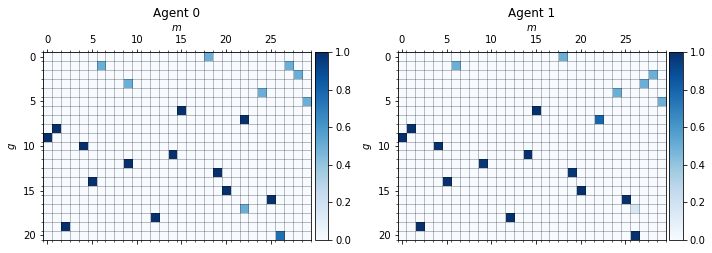

In [47]:
imgs = []
from mpl_toolkits.axes_grid1 import make_axes_locatable
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")

                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                    
                
                
                a=ax.matshow(matrix, cmap=plt.cm.Blues,interpolation="nearest",vmin=0, vmax=1)
                ax.set_xticks(np.arange(-0.5, 30, 1),minor=True)
                ax.set_yticks(np.arange(-0.5, 21, 1),minor=True)
                
                
                ax.grid(which="minor",color='black', linestyle='-', linewidth=0.5,alpha=0.5)
                
                ax.set_ylabel("$g$")
                ax.set_xlabel("$m$")
                ax.xaxis.set_label_position('top')
                divider = make_axes_locatable(ax)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(a, cax=cax, orientation='vertical')
                
                
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    
                    plt.tight_layout()
 

                    if(checkpoint_file[-2:]=="20" and checkpoint_file[-3]=="-"):
                        print("a")
                        plt.savefig("20.pdf",bbox_inches='tight')
                    elif(checkpoint_file[-3:]=="500" ):
                        plt.savefig("500.pdf",bbox_inches='tight')
                    elif(checkpoint_file[-4:]=="1000" ):
                        plt.savefig("1000.pdf",bbox_inches='tight')
                        
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [12]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func

In [13]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()